In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
%matplotlib inline


In [2]:
boston = datasets.load_boston()


In [3]:
"""
Artificial linear data using the same number of features and observations as the
Boston housing prices dataset for assumption test comparison
"""
linear_X, linear_y = datasets.make_regression(n_samples=boston.data.shape[0],
                                              n_features=boston.data.shape[1],
                                              noise=75, random_state=46)

# Setting feature names to x1, x2, x3, etc. if they are not defined
linear_feature_names = ['X'+str(feature+1) for feature in range(linear_X.shape[1])]

In [6]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['HousePrice'] = boston.target

df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,HousePrice
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before we test the assumptions, we’ll need to fit our linear regression models. I have a master function for performing all of the assumption testing at the bottom of this post that does this automatically, but to abstract the assumption tests out to view them independently we’ll have to re-write the individual tests to take the trained model as a parameter.

Additionally, a few of the tests use residuals, so we’ll write a quick function to calculate residuals. These are also calculated once in the master function at the bottom of the page, but this extra function is to adhere to DRY typing for the individual tests that use residuals.



In [7]:
from sklearn.linear_model import LinearRegression

# Fitting the model
boston_model = LinearRegression()
boston_model.fit(boston.data, boston.target)

# Returning the R^2 for the model
boston_r2 = boston_model.score(boston.data, boston.target)
print('R^2: {0}'.format(boston_r2))

R^2: 0.7406426641094094


In [8]:
linear_model = LinearRegression()
linear_model.fit(linear_X, linear_y)

# Returning the R^2 for the model
linear_r2 = linear_model.score(linear_X, linear_y)
print('R^2: {0}'.format(linear_r2))


R^2: 0.873743725796525


In [9]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

1) Linearity

This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive.

Why it can happen: There may not just be a linear relationship among the data. Modeling is about trying to estimate a function that explains a process, and linear regression would not be a fitting estimator (pun intended) if there is no linear relationship.

What it will affect: The predictions will be extremely inaccurate because our model is underfitting. This is a serious violation that should not be ignored.

How to detect it: If there is only one predictor, this is pretty easy to test with a scatter plot. Most cases aren’t so simple, so we’ll have to modify this by using a scatter plot to see our predicted values versus the actual values (in other words, view the residuals). Ideally, the points should lie on or around a diagonal line on the scatter plot.

How to fix it: Either adding polynomial terms to some of the predictors or applying nonlinear transformations . If those do not work, try adding additional variables to help capture the relationship between the predictors and the label.



In [10]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


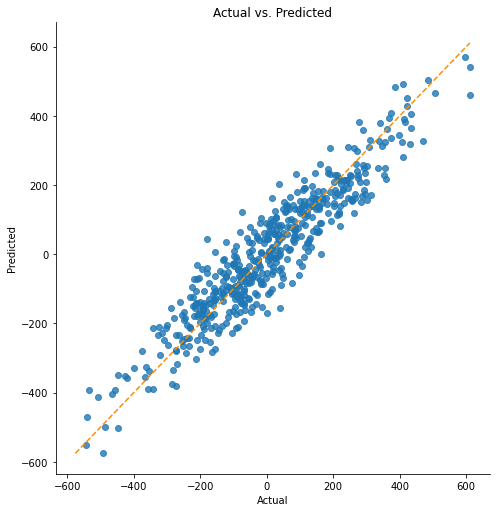

In [11]:
linear_assumption(linear_model, linear_X, linear_y)


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


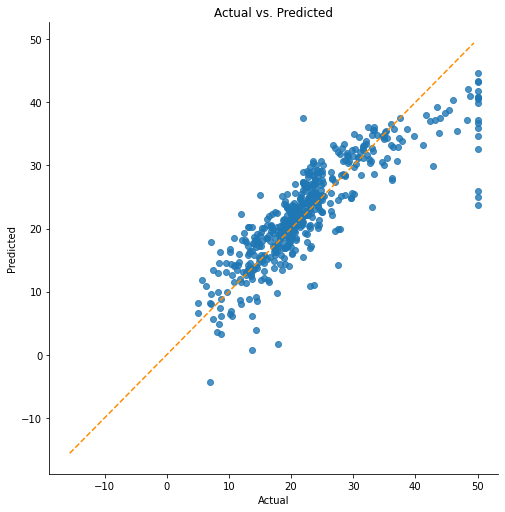

In [12]:
linear_assumption(boston_model, boston.data, boston.target)


# We can see in this case that there is not a perfect linear relationship. Our predictions are biased towards lower values in both the lower end (around 5-10) and especially at the higher values (above 40).



# II) Normality of the Error

More specifically, this assumes that the error terms of the model are normally distributed. Linear regressions other than Ordinary Least Squares (OLS) may also assume normality of the predictors or the label, but that is not the case here.

Why it can happen: This can actually happen if either the predictors or the label are significantly non-normal. Other potential reasons could include the linearity assumption being violated or outliers affecting our model.

What it will affect: A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals.

How to detect it: There are a variety of ways to do so, but we’ll look at both a histogram and the p-value from the Anderson-Darling test for normality.

How to fix it: It depends on the root cause, but there are a few options. Nonlinear transformations of the variables, excluding specific variables (such as long-tailed variables), or removing outliers may solve this problem.

In [15]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.3350660458465171
Residuals are normally distributed


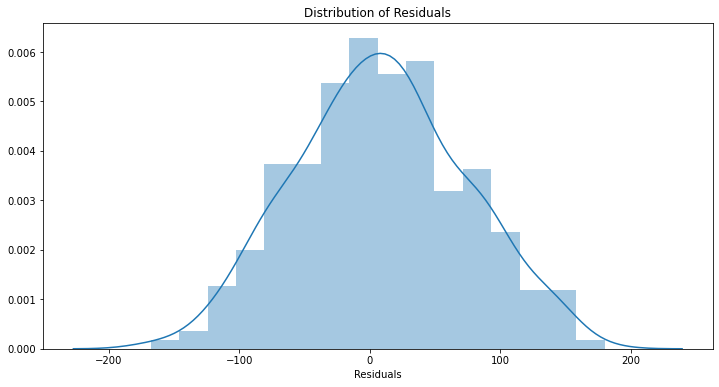


Assumption satisfied


In [16]:
normal_errors_assumption(linear_model, linear_X, linear_y)

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 8.311128328210816e-25
Residuals are not normally distributed


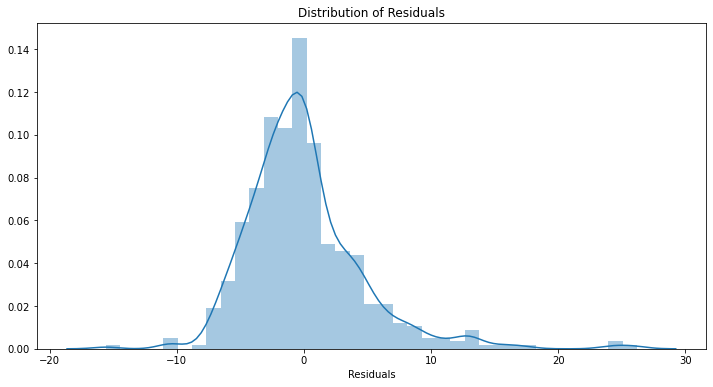


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [17]:
normal_errors_assumption(boston_model, boston.data, boston.target)


# III) No Multicollinearity among PREDICTORS
This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.

Why it can happen: A lot of data is just naturally correlated. For example, if trying to predict a house price with square footage, the number of bedrooms, and the number of bathrooms, we can expect to see correlation between those three variables because bedrooms and bathrooms make up a portion of square footage.

What it will affect: Multicollinearity causes issues with the interpretation of the coefficients. Specifically, you can interpret a coefficient as “an increase of 1 in this predictor results in a change of (coefficient) in the response variable, holding all other predictors constant.” This becomes problematic when multicollinearity is present because we can’t hold correlated predictors constant. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

How to detect it: There are a few ways, but we will use a heatmap of the correlation as a visual aid and examine the variance inflation factor (VIF).

How to fix it: This can be fixed by other removing predictors with a high variance inflation factor (VIF) or performing dimensionality reduction.

In [19]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')


Assumption 3: Little to no multicollinearity among predictors


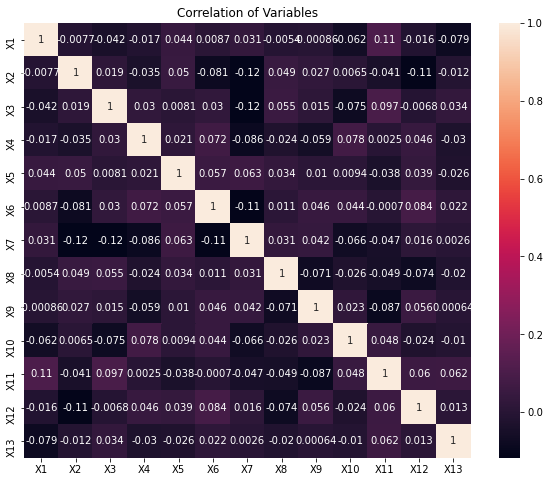

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X1: 1.030931170297102
X2: 1.0457176802992108
X3: 1.0418076962011935
X4: 1.0269600632251443
X5: 1.0199882018822783
X6: 1.0404194675991594
X7: 1.0670847781889177
X8: 1.0229686036798158
X9: 1.0292923730360835
X10: 1.0289003332516535
X11: 1.0520432208216244
X12: 1.0336719449364813
X13: 1.0140788728975834

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied


In [20]:
multicollinearity_assumption(linear_model, linear_X, linear_y, linear_feature_names)


Assumption 3: Little to no multicollinearity among predictors


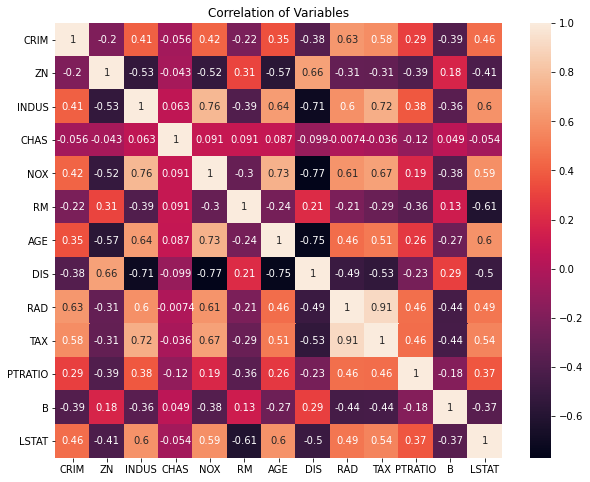

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
CRIM: 2.1003728199615233
ZN: 2.8440132669462637
INDUS: 14.485757706539331
CHAS: 1.1529518589418775
NOX: 73.89494652814788
RM: 77.94828304638538
AGE: 21.38685048994314
DIS: 14.699652383749175
RAD: 15.167724857920897
TAX: 61.227274009649456
PTRATIO: 85.02954731061801
B: 20.10494263622909
LSTAT: 11.102024772203539

10 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [21]:
multicollinearity_assumption(boston_model, boston.data, boston.target, boston.feature_names)


# IV) No Autocorrelation of the Error Terms
This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model.

Why it can happen: In a time series scenario, there could be information about the past that we aren’t capturing. In a non-time series scenario, our model could be systematically biased by either under or over predicting in certain conditions. Lastly, this could be a result of a violation of the linearity assumption.

What it will affect: This will impact our model estimates.

How to detect it: We will perform a Durbin-Watson test to determine if either positive or negative correlation is present. Alternatively, you could create plots of residual autocorrelations.

How to fix it: A simple fix of adding lag variables can fix this problem. Alternatively, interaction terms, additional variables, or additional transformations may fix this.

In [22]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [23]:
autocorrelation_assumption(linear_model, linear_X, linear_y)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0034505138459093
Little to no autocorrelation 

Assumption satisfied


In [24]:
autocorrelation_assumption(boston_model, boston.data, boston.target)


Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.0715916506006826
Signs of positive autocorrelation 

Assumption not satisfied


We’re having signs of positive autocorrelation here, but we should expect this since we know our model is consistently under-predicting and our linearity assumption is being violated. Since this isn’t a time series dataset, lag variables aren’t possible. Instead, we should look into either interaction terms or additional transformations.



# V) Homoscedasticity
This assumes homoscedasticity, which is the same variance within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.

Why it can happen: Our model may be giving too much weight to a subset of the data, particularly where the error variance was the largest.

What it will affect: Significance tests for coefficients due to the standard errors being biased. Additionally, the confidence intervals will be either too wide or too narrow.

How to detect it: Plot the residuals and see if the variance appears to be uniform.

How to fix it: Heteroscedasticity (can you tell I like the scedasticity words?) can be solved either by using weighted least squares regression instead of the standard OLS or transforming either the dependent or highly skewed variables. Performing a log transformation on the dependent variable is not a bad place to start.

In [29]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    print(df_results.head())

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
       Actual   Predicted   Residuals
0  -73.679738 -140.469681  -66.789944
1  -55.992365  -66.843867  -10.851503
2 -260.265513 -137.227020  123.038493
3 -361.585769 -326.979397   34.606373
4 -446.070855 -348.788488   97.282367


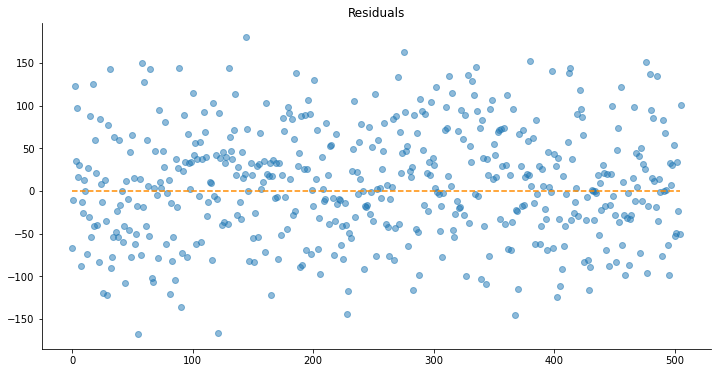

In [30]:
homoscedasticity_assumption(linear_model, linear_X, linear_y)


Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
   Actual  Predicted  Residuals
0    24.0  30.003843  -6.003843
1    21.6  25.025562  -3.425562
2    34.7  30.567597   4.132403
3    33.4  28.607036   4.792964
4    36.2  27.943524   8.256476


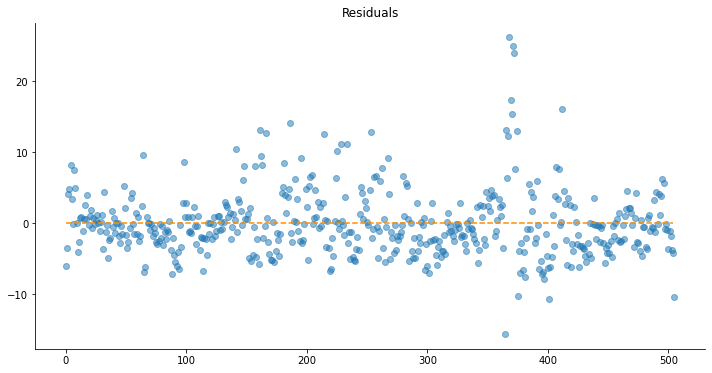

In [31]:
homoscedasticity_assumption(boston_model, boston.data, boston.target)


In [32]:
def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    from sklearn.linear_model import LinearRegression
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    print()
    print('R^2:', r2, '\n')
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')
        
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
       
        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
        
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
        
    linear_assumption()
    normal_errors_assumption()
    multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()
